In [0]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as trans
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [0]:
class Adam:
  def __init__(self,parameters,lr,beta1=0.9,beta2=0.999,epsilon=1e-8):
    self.x_states = list(parameters)
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.m_states = [t.data.clone().zero_() for t in self.x_states]
    self.v_states = [t.data.clone().zero_() for t in self.x_states]
    self.nsteps = 0

  def zero_grad(self):
    for x in self.x_states:
      if x.grad is not None:
        x.grad.data.zero_()

  def step(self):
    self.nsteps += 1
    for x,m,v in zip(self.x_states,self.m_states,self.v_states):
      g = x.grad.data
      m.mul_(self.beta1).add_(g.mul(1-self.beta1))
      v.mul_(self.beta2).add_(g.mul_(g).mul_(1-self.beta2))
      m_bias = 1-self.beta1**self.nsteps
      v_bias = 1-self.beta2**self.nsteps
      lr = self.lr*math.sqrt(v_bias)/m_bias
      x.data.add_(m.mul_(-lr)/(v.sqrt()+self.epsilon))




In [0]:
class RMSProp:
  def __init__(self,parameters,lr,gamma=0.9,epsilon=1e-8):
    self.x_states = list(parameters)
    self.lr = lr
    self.gamma = gamma
    self.epsilon = epsilon
    self.v_states = [t.data.clone().zero_() for t in self.x_states]

  def zero_grad(self):
    for x in self.x_states:
      if x.grad is not None:
        x.grad.data.zero_()

  def step(self):
    for x,v in zip(self.x_states,self.v_states):
      g = x.grad.data
      v.mul_(1-self.gamma).add_(torch.mul(g*g,self.gamma))
      x.data.add_(g.mul_(-self.lr)/(v.sqrt()+self.epsilon))


In [0]:
def eval(model,criterion,dataloader):
  loss,acc = 0,0
  for bx,by in dataloader:
    bx = bx.view(-1,784)
    logit = model(bx)
    err = criterion(logit,by)
    loss += err.item()
    _,pred_y = logit.max(dim=1)
    acc += (pred_y.data==by).float().sum()/bx.size(0)

  loss /= len(dataloader)
  acc /= len(dataloader)
  return loss,acc

In [0]:
trainset = dsets.MNIST(root='../data/mnist',train=True,transform=trans.ToTensor(),download=True)
testset = dsets.MNIST(root='../data/mnist',train=False,transform=trans.ToTensor(),download=True)
train_loader = DataLoader(trainset,batch_size=128,shuffle=True,num_workers=6)
test_loader = DataLoader(testset,batch_size=128,shuffle=False,num_workers=6)

In [35]:
model = nn.Sequential(nn.Linear(784,500),nn.ReLU(),nn.Linear(500,300),nn.ReLU(),
                      nn.Linear(300,10))
criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(),lr=0.01)
optimizer = RMSProp(model.parameters(),lr=0.01)
train_history = []
nepoch = 30
for epoch in range(nepoch):
  for bx,by in train_loader:
    bx = bx.view(-1,784)
    optimizer.zero_grad()
    logit = model(bx)
    err = criterion(logit,by)
    err.backward()
    optimizer.step()
  loss,acc = eval(model,criterion,train_loader)
  loss1,acc1 = eval(model,criterion,test_loader)
  print("[%3d/%d] |\t train_error:%.1e,train_acc:%.2f |\t test_error:%.1e,test_acc:%.2f"%(
      epoch+1,nepoch,loss,acc,loss1,acc1
  ))
  train_history.append((loss,acc,loss1,acc1))

[  1/30] |	 train_error:5.3e-01,train_acc:0.94 |	 test_error:5.7e-01,test_acc:0.93
[  2/30] |	 train_error:4.7e-01,train_acc:0.95 |	 test_error:5.6e-01,test_acc:0.95
[  3/30] |	 train_error:5.4e-01,train_acc:0.95 |	 test_error:6.5e-01,test_acc:0.95
[  4/30] |	 train_error:3.8e-01,train_acc:0.96 |	 test_error:5.8e-01,test_acc:0.95
[  5/30] |	 train_error:4.9e-01,train_acc:0.96 |	 test_error:8.4e-01,test_acc:0.95
[  6/30] |	 train_error:2.7e-01,train_acc:0.97 |	 test_error:5.5e-01,test_acc:0.96
[  7/30] |	 train_error:4.6e-01,train_acc:0.97 |	 test_error:7.0e-01,test_acc:0.96
[  8/30] |	 train_error:7.6e-01,train_acc:0.95 |	 test_error:1.2e+00,test_acc:0.95
[  9/30] |	 train_error:3.8e-01,train_acc:0.97 |	 test_error:9.2e-01,test_acc:0.96
[ 10/30] |	 train_error:5.7e-01,train_acc:0.96 |	 test_error:1.2e+00,test_acc:0.95
[ 11/30] |	 train_error:6.2e-01,train_acc:0.96 |	 test_error:1.2e+00,test_acc:0.94
[ 12/30] |	 train_error:4.6e-01,train_acc:0.96 |	 test_error:9.2e-01,test_acc:0.95
[ 13

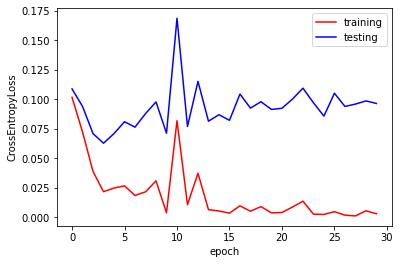

In [24]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([t[0] for t in train_history],'r',label='training')
plt.plot([t[2] for t in train_history],'b',label='testing')
plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')
plt.legend()

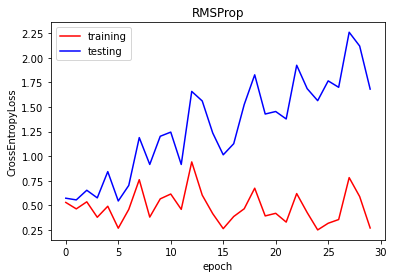

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([t[0] for t in train_history],'r',label='training')
plt.plot([t[2] for t in train_history],'b',label='testing')
plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')
plt.title("RMSProp")
plt.legend()